In [26]:
# Import local modules
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [27]:
import pandas as pd
from preprocessing import VandalismEncoder, RevisionGrouper, FeatureSelector
from persistence import save_model
from baseline import BASELINE_FEATURE_COLUMNS
from plotting import plot_confusion_matrix
from undersampling import undersample_1_1, undersample_15_1, undersample_2_1, undersample_25_1, undersample_3_1, undersample_5_1, undersample_10_1
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, GridSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from ipywidgets import interactive

In [28]:
# Import dataset
df = pd.read_csv('./data/features-total-2f8f6676.csv', index_col='revision_id')
df.head()

,isContributorAnonymous,isBot,timeOfDay,localizedTimeOfDay,dayOfWeek,localizedDayOfWeek,isMinorEdit,authorRank,authorRankOfLast200Edits,authorRankOneMonth,...,rawCommentLength,userCommentLength,hasNumericOutlierInColumns,hasNumericOutlierInRows,tableDataTypeInformationGain,templateUseFlags,templateUseFifaFlags,templateUsePageLink,templateUseYesNo,tag_id
revision_id,,,,,,,,,,,,,,,,,,,,,
228189784,0.0,0.0,13.0,-1.0,7.0,-1.0,0.0,0.000000,0.000000,0.0,...,34.0,34.0,0.0,0.0,-1.000000,0.0,0.0,0.0,0.0,12
730449352,0.0,0.0,2.0,-1.0,2.0,-1.0,0.0,0.833333,0.857143,0.5,...,14.0,0.0,1.0,0.0,0.134129,0.0,0.0,0.0,0.0,12
216224416,0.0,0.0,17.0,-1.0,6.0,-1.0,1.0,0.000000,0.000000,0.0,...,67.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,12
539338621,0.0,1.0,1.0,-1.0,4.0,-1.0,1.0,0.000000,0.000000,0.0,...,152.0,0.0,0.0,0.0,-1.000000,0.0,0.0,0.0,0.0,12
746191686,1.0,0.0,20.0,23.0,2.0,2.0,0.0,-1.000000,-1.000000,-1.0,...,10.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,12


---
## Preprocessing

In [29]:
def preprocessing(frame, features='all', tag=1):
    feature_columns = None
    
    if features == 'baseline':
        feature_columns = BASELINE_FEATURE_COLUMNS

    preprocess_pipeline = Pipeline([
        ('vandalism_encoder', VandalismEncoder([tag])),
        ('revision_grouper', RevisionGrouper()),
        ('feature_selector', FeatureSelector(feature_columns))
    ])

    print('Feature config:', features, 'Selected tag:', tag)
    return preprocess_pipeline.transform(frame)

---
## Generate single label classifier per tag

Feature config: all Selected tag: 1
X train (3720, 108)
y train (3720,)
X test (1240, 108)
y test (1240,)
Best params {'max_features': 1.0, 'n_estimators': 300, 'ratio': <function undersample_5_1 at 0x11a285510>}
Best score 0.6970132451510183


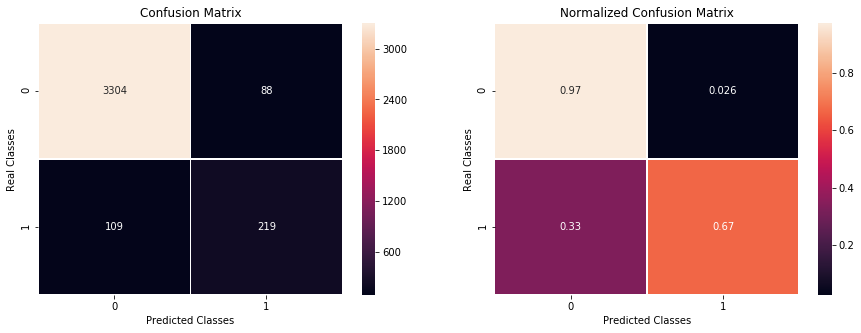

Classification Report
              precision    recall  f1-score   support

No Vandalism       0.97      0.97      0.97      3392
   Vandalism       0.71      0.67      0.69       328

 avg / total       0.95      0.95      0.95      3720

Feature config: all Selected tag: 2
X train (3720, 108)
y train (3720,)
X test (1240, 108)
y test (1240,)
Best params {'max_features': 1.0, 'n_estimators': 300, 'ratio': <function undersample_2_1 at 0x11a285378>}
Best score 0.5392141128351207


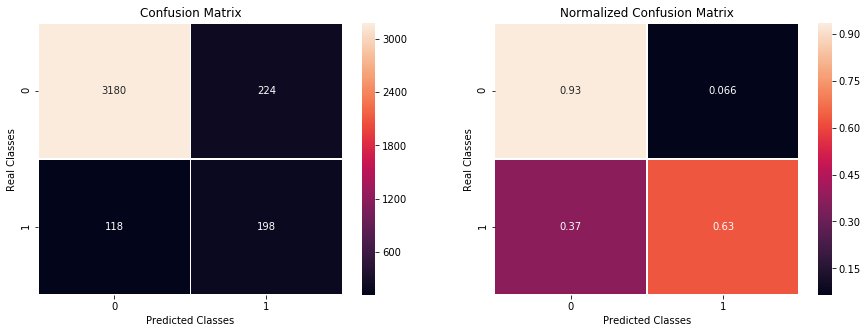

Classification Report
              precision    recall  f1-score   support

No Vandalism       0.96      0.93      0.95      3404
   Vandalism       0.47      0.63      0.54       316

 avg / total       0.92      0.91      0.91      3720

Feature config: all Selected tag: 3
X train (3720, 108)
y train (3720,)
X test (1240, 108)
y test (1240,)


/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

Best params {'max_features': 1.0, 'n_estimators': 300, 'ratio': 'majority'}
Best score 0.19295892428855685


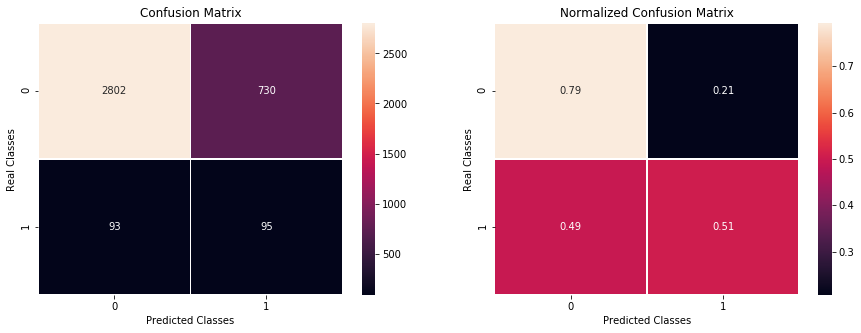

Classification Report
              precision    recall  f1-score   support

No Vandalism       0.97      0.79      0.87      3532
   Vandalism       0.12      0.51      0.19       188

 avg / total       0.92      0.78      0.84      3720

Feature config: all Selected tag: 5
X train (3720, 108)
y train (3720,)
X test (1240, 108)
y test (1240,)
Best params {'max_features': 1.0, 'n_estimators': 300, 'ratio': <function undersample_15_1 at 0x11a2852f0>}
Best score 0.4514336857413948


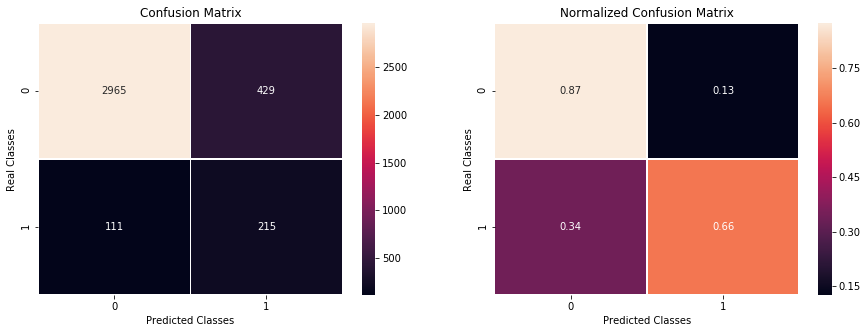

Classification Report
              precision    recall  f1-score   support

No Vandalism       0.96      0.87      0.92      3394
   Vandalism       0.33      0.66      0.44       326

 avg / total       0.91      0.85      0.88      3720

Feature config: all Selected tag: 6
X train (3720, 108)
y train (3720,)
X test (1240, 108)
y test (1240,)
Best params {'max_features': 1.0, 'n_estimators': 300, 'ratio': <function undersample_5_1 at 0x11a285510>}
Best score 0.23949749940462017


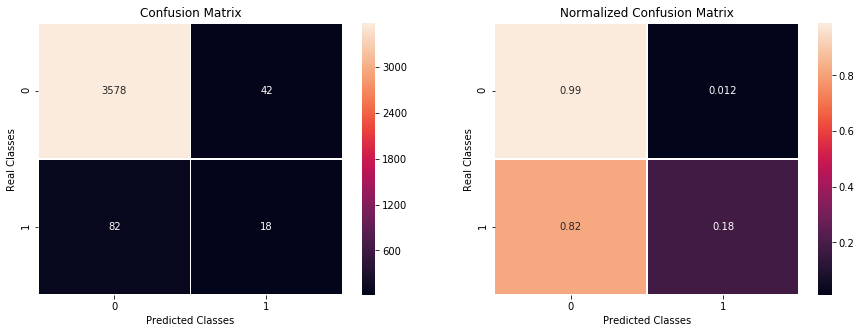

Classification Report
              precision    recall  f1-score   support

No Vandalism       0.98      0.99      0.98      3620
   Vandalism       0.30      0.18      0.23       100

 avg / total       0.96      0.97      0.96      3720

Feature config: all Selected tag: 9
X train (3720, 108)
y train (3720,)
X test (1240, 108)
y test (1240,)
Best params {'max_features': 1.0, 'n_estimators': 300, 'ratio': <function undersample_3_1 at 0x11a285488>}
Best score 0.2158076250213347


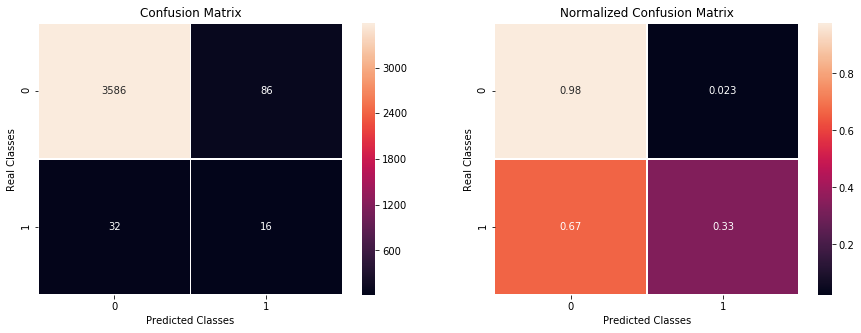

Classification Report
              precision    recall  f1-score   support

No Vandalism       0.99      0.98      0.98      3672
   Vandalism       0.16      0.33      0.21        48

 avg / total       0.98      0.97      0.97      3720

Feature config: all Selected tag: 11
X train (3720, 108)
y train (3720,)
X test (1240, 108)
y test (1240,)
Best params {'max_features': 1.0, 'n_estimators': 300, 'ratio': <function undersample_2_1 at 0x11a285378>}
Best score 0.5773235817919907


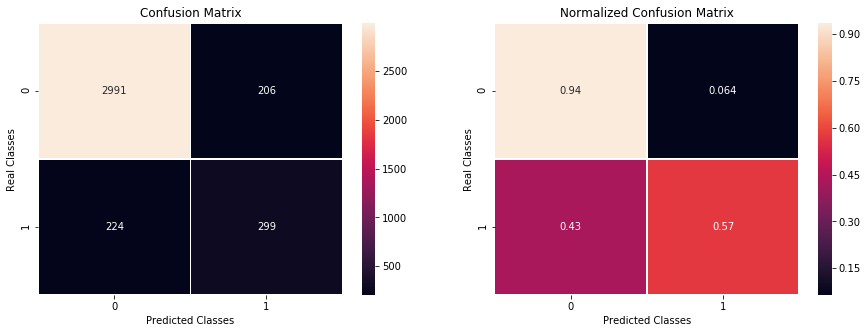

Classification Report
              precision    recall  f1-score   support

No Vandalism       0.93      0.94      0.93      3197
   Vandalism       0.59      0.57      0.58       523

 avg / total       0.88      0.88      0.88      3720

Feature config: all Selected tag: 12
X train (3720, 108)
y train (3720,)
X test (1240, 108)
y test (1240,)
Best params {'max_features': 1.0, 'n_estimators': 300, 'ratio': <function undersample_10_1 at 0x11a285598>}
Best score 0.8709239549939828


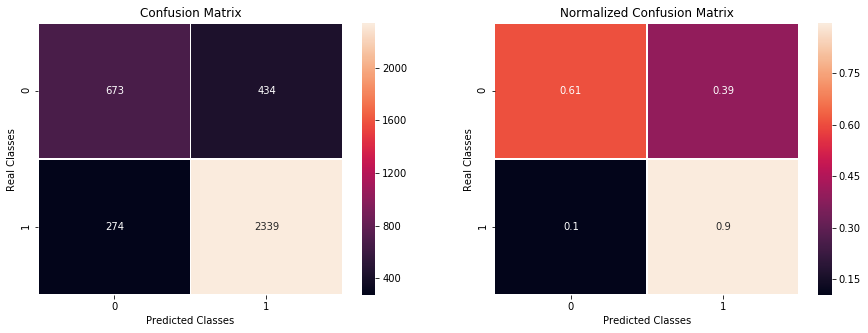

Classification Report
              precision    recall  f1-score   support

No Vandalism       0.71      0.61      0.66      1107
   Vandalism       0.84      0.90      0.87      2613

 avg / total       0.80      0.81      0.81      3720



In [30]:
for tag in [1, 2, 3, 5, 6, 9, 11, 12]:
    processed_df = preprocessing(df, 'all', tag)
    # X, y split
    X = processed_df.drop(['is_vandalism'], axis=1)
    y = processed_df['is_vandalism']
    
    # Train / test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    print('X train', X_train.shape)
    print('y train', y_train.shape)
    print('X test', X_test.shape)
    print('y test', y_test.shape)
    
    # Grid search model params
    parameters = [{
        'n_estimators': [300],
        'max_features': [1.0],
        'ratio': [
            'majority',
            undersample_15_1,
            undersample_2_1,
            undersample_25_1,
            undersample_3_1,
            undersample_5_1,
            undersample_10_1
        ]
    }]

    # Custom scoring: Use only f1 of vandalism class
    scores = {
        'f1_vandalism': make_scorer(f1_score, labels=[1], average=None),
        'f1': make_scorer(f1_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'roc_auc': make_scorer(roc_auc_score)
    }

    grid_search = GridSearchCV(BalancedBaggingClassifier(DecisionTreeClassifier()),
                               parameters, 
                               scoring=scores,
                               refit='f1_vandalism',
                               cv=10,
                               n_jobs=-1)
    grid_search.fit(X_train, y_train)

    params = grid_search.best_params_
    print('Best params', grid_search.best_params_)
    print('Best score', grid_search.best_score_)
    
    # Train scores & predictions
    clf = BalancedBaggingClassifier(DecisionTreeClassifier(),
                                n_estimators=params['n_estimators'],
                                max_features=params['max_features'],
                                ratio=params['ratio'])
    
    train_scores = cross_validate(clf, X_train, y_train,
                            scoring=['f1', 'f1_micro', 'precision', 'recall', 'roc_auc', 'accuracy'],
                            cv=10, n_jobs=-1, return_train_score=False)

    y_train_predict = cross_val_predict(clf, X_train, y_train, cv=10, n_jobs=-1, method='predict')
    plot_confusion_matrix(y_train, y_train_predict)
    
    save_model(tag, clf, train_scores, grid_search)